# Traitement avancées : modèles & carte




## 1. Chargement et recodage

In [19]:
import pandas as pd
import pyshs
import matplotlib.pyplot as plt
import pyreadstat
data, meta = pyreadstat.read_sav('./wgm-full-wave2-public-file.sav')
def question(v,meta):
    return meta.column_names_to_labels[v]

def modalites(v,meta):
    return meta.value_labels[meta.variable_to_label[v]]

data = data[data["COUNTRYNEW"]=="Switzerland"]


data["poids"] = data["WGT"]

data["pays"] = data["COUNTRYNEW"]
data["age"] = data["Age"].fillna("NA")
data["age_reco"] = pd.cut(data['Age'],[0,35,45,55,65,100],
                labels = ["1-[15-35[","2-[35-45[","3-[45-55[","4-[55-65[","5-[65-75]"])
data["genre"] = data["Gender"].replace({1.0: '1-Male', 2.0: '2-Female'})
data["education"] = data["Education"].replace(modalites('Education',meta)).replace({99:None})
data["revenus"] = data["Household_Income"].replace({1.0: 'Q1', 2.0: 'Q2',3:"Q3",4:"Q4",5:"Q5"})
data["region"] = data["Global11Regions"].replace(modalites("Global11Regions",meta))
data["revenus_avis"] = data["Subjective_Income"].replace(modalites("Subjective_Income",meta))

reco = {1:"1-A lot", 2:"2-Some", 3:"3-Not much/at all",4:"3-Not much/at all",99:"4-NA"}
data["connaissance_science"] = data['W1'].replace(reco)
data["comprendre_science"] = data['W2'].replace(reco)
data["education_science"] = data["W3"].replace(modalites('W3',meta))
data["confiance_hopital"] = data["W4"].replace(reco)
data["confiance_science"] = data["W6"].replace(reco)
data["confiance_gouvernement"] = data["W5B"].replace(reco)
data["confiance_scientifiques"] = data["W5C"].replace(reco)
data["confiance_journalistes"] = data["W5D"].replace(reco)
data["confiance_medecins"] = data["W5E"].replace(reco)
data["confiance_rebouteux"] = data["W5G"].replace(reco)
data["recherche_cancer"] = data['MH4A'].replace(modalites("MH4A",meta)).fillna("NA")

reco = {1:"1-A lot", 2:"2-Some", 3:"3-Not much/at all",4:"3-DK",8:"3-DK",9:"3-DK"}
data["covid_impact"] = data["WP21757"].replace(reco)


data["gouvernants_valorisent_scientifiques"] = data["W7C"].replace(reco)

data["socialmedia_month"] = data["W27"].replace(modalites("W27",meta))
reco = {1.0: '1-Almost every hour',2.0: '1-Almost every hour',3.0: '2-At least once a day',
 4.0: '2-At least once a day', 5.0: '3-A few days a week', 6.0: '4-Less frequently', 99.0: '5-DK/Refused'}
data["socialmedia_freq"] = data["W28"].replace(reco)
reco = {1:"1-Très souvent ou tout le temps",2:"1-Très souvent ou tout le temps",3:"2-Parfois",4:"3-Jamais",99:"NA"}
data["socialmedia_healthinfo"] = data["W29"].replace(reco)

data["science_religion"] = data["W30"].replace(modalites("W30",meta))
data["vaccin"] = data["WP21768"].replace(modalites("WP21768",meta))

data["scientists_benefits_people"] = data["W8"].replace({1:"1-Yes",2:"2-Some",3:"3-No",99:"4-NA"})
data["scientists_benefits_you"] = data["W9"].replace({1:"1-Yes",2:"2-Some",3:"3-No",99:"4-NA"})

## 2. Analyse statistique avancée

### Régression logistique

Une possibilité: utiliser statsmodels https://www.statsmodels.org/stable/discretemod.html

Par exemple les facteurs de défiance (partielle) dans l'hopital

In [ ]:
pyshs.tri_a_plat(data,"confiance_hopital")

Créer une variable dichotomisée dépendante 1/0

In [ ]:
data["confiance_hopital_faible"] = data["confiance_hopital"].apply(lambda x : 0 if x=="1-A lot" else 1)

"à la main"

In [ ]:
import statsmodels.formula.api as smf

log_reg = smf.logit("confiance_hopital_faible ~ genre ", data=data)
log_reg = log_reg.fit()
log_reg.summary()

Définir nos variables indépendantes

En passant par une bibliothèque dédiée

In [ ]:
pyshs.regression_logistique(data,"confiance_hopital_faible",["genre"])

Tout l'enjeu est la mise en forme

In [ ]:
var_ind = {"genre":"Genre","age_reco":"Age","education":"Education","revenus":"Revenus",
           "covid_impact":"Impacté par le COVID",
            "scientists_benefits_people":"Science bénéfique aux gens"}

In [2]:
pyshs.regression_logistique(data,"confiance_hopital_faible",var_ind,"poids")

NameError: name 'data' is not defined

## Représentations géographiques

Pour cela on utilise GéoPandas qui est une extension de Pandas

Il faut un fond de carte, généralement en shapefiles : https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/

In [20]:
#!conda install geopandas

In [21]:
import geopandas as gpd

Geopandas permet de manipuler ce type de fichiers comme les GIS

In [6]:
carte = gpd.read_file("./world-administrative-boundaries/world-administrative-boundaries.shp")

Une nouvelle colonne

In [7]:
carte

,status,color_code,region,iso3,continent,name,iso_3166_1_,french_shor,geometry
0,Member State,SMR,Southern Europe,SMR,Europe,San Marino,SM,Saint-Marin,"POLYGON ((12.40913 43.90842, 12.40352 43.92092..."
1,Member State,SYR,Western Asia,SYR,Asia,Syrian Arab Republic,SY,RÃ©publique arabe syrienne,"POLYGON ((42.35562 37.10693, 42.37833 37.07206..."
2,Member State,LVA,Northern Europe,LVA,Europe,Latvia,LV,Lettonie,"POLYGON ((27.37206 57.53564, 27.42500 57.53194..."
3,Member State,CPV,Western Africa,CPV,Africa,Cape Verde,CV,Cabo Verde,"MULTIPOLYGON (((-24.36556 14.81292, -24.39000 ..."
4,Member State,ZMB,Eastern Africa,ZMB,Africa,Zambia,ZM,Zambie,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583..."
...,...,...,...,...,...,...,...,...,...
251,FR Territory,FRA,Caribbean,MTQ,Americas,Martinique,MQ,Martinique,"POLYGON ((-60.81695 14.47333, -60.82056 14.455..."
252,Member State,MYS,South-Eastern Asia,MYS,Asia,Malaysia,MY,Malaisie,"MULTIPOLYGON (((111.41152 2.37639, 111.36804 2..."
253,Member State,KEN,Eastern Africa,KEN,Africa,Kenya,KE,Kenya,"MULTIPOLYGON (((41.13805 -2.12444, 41.09416 -2..."
254,PT Territory,PRT,Southern Europe,None,Europe,Madeira Islands,None,Madeira Islands,"POLYGON ((-17.10250 32.82333, -17.05306 32.809..."


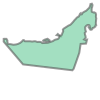

In [9]:
carte["geometry"].iloc[11]

L'enjeu maintenant est d'afficher les données sur la carte : rajouter une colonne à notre jeu

Vérifions que le nom des pays est écrit de la même manière dans le jeu de données et dans la carte

In [148]:
noms_cartes = carte["name"].unique()
noms_data = data["COUNTRYNEW"].unique()

for i in noms_data:
    if not i in noms_cartes:
        print(i)

United States
United Kingdom
Iran
Tanzania
Laos
South Korea
Moldova
Russia
Bosnia Herzegovina
Congo Brazzaville
Ivory Coast
North Macedonia
Kosovo


Ce sont les noms qu'il faut relier, donc on va créer un dictionnaire de correspondances et créer une nouvelle colonne avec les noms recodées

In [13]:
reco = {   
    "United States":'United States of America',
    "United Kingdom":'U.K. of Great Britain and Northern Ireland',
    "Iran":'Iran (Islamic Republic of)',
    "Tanzania":'United Republic of Tanzania',
    "South Korea":'Republic of Korea',
    'Moldova':'Moldova, Republic of',
    "Russia":'Russian Federation',
    "Bosnia Herzegovina":'Bosnia & Herzegovina',
    "Congo Brazzaville":'Democratic Republic of the Congo',
    "North Macedonia":'The former Yugoslav Republic of Macedonia'
    }

# reste à faire Kosovo et Ivory Coast
data["pays_reco"] = data["pays"].replace(reco) 

Il est possible maintenant de créer des données par pays à partir du sondage. On va calculer par pays la proportion de ceux qui ont confiance

In [15]:
# Construire une fonction dédiée qui traite un tableau pandas
def prop_lot(x):
    t = pyshs.tri_a_plat(x,"confiance_hopital","poids")
    try:
        return t.loc["1-A lot","Pourcentage (%)"]
    except:
        return None

# L'appliquer à la sortie d'un groupby, trier et afficher
#data.groupby("pays").apply(prop_lot).sort_values().plot(kind="barh",figsize=(5,30))

In [16]:
data_pays = pd.DataFrame(data.groupby("pays_reco").apply(prop_lot),columns=["Confiance hopital"])

Et de les associer à la carte

In [17]:
carte_data = carte.join(data_pays,on="name")

Pour construire une visualisation (plus de détail par exemple sur  https://geopandas.org/en/stable/docs/user_guide/mapping.html)

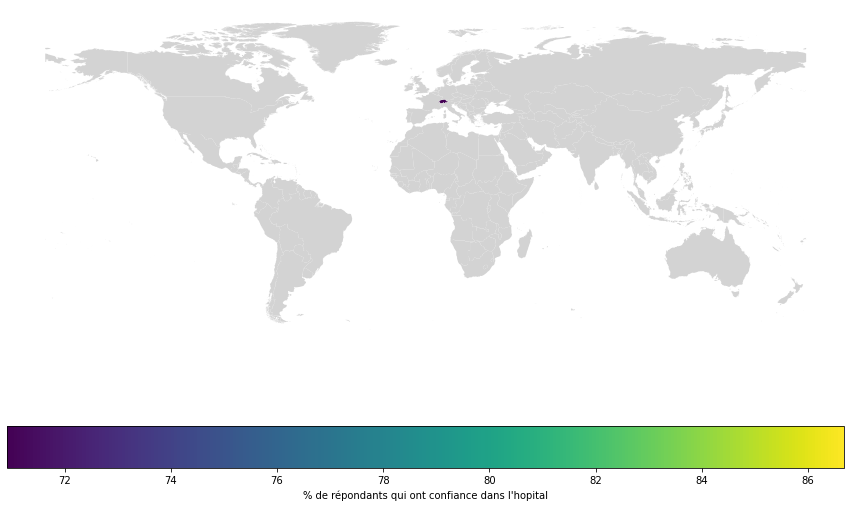

In [18]:
ax = carte_data.plot(column='Confiance hopital',figsize=(15,10),legend=True,
                legend_kwds={'label': "% de répondants qui ont confiance dans l'hopital",
                             'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
ax.set_axis_off()

Une deuxième carte sur l'impression que la science apporte des bénéfices directe aux répondants